# Exploración y analisis de modelos entrenados - EXP 2

In [2]:
import sys
import os 
import torch
import pandas as pd
import torchaudio.transforms as T
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

sys.path.append(os.path.abspath(os.path.join('../..','iESPnet_SRC_main','utilities')))
from Generator import SeizureDatasetLabelTime, scale_spec, permute_spec, smoothing_label
from Model import iESPnet
from TrainEval import train_model_opt, test_model, train_model, get_thr_output, get_performance_indices

sys.path.append(os.path.abspath(os.path.join('..','05-Train-Test')))
from utilit_train_test import make_weights_for_balanced_classes

In [4]:
meta_data_file_process   = '/media/martin/Disco2/Rns_Data/PITT_PI_process/METADATA_process/allfiles_metadata.csv'
meta_data_file_noprocess = '/media/martin/Disco2/Rns_Data/PITT_PI_noprocess/METADATA_noprocess/allfiles_metadata.csv'

df_meta_process   = pd.read_csv(meta_data_file_process)
df_meta_noprocess = pd.read_csv(meta_data_file_noprocess)

df_meta_process.drop(df_meta_process[df_meta_process['label'] == 2].index, inplace = True)
df_meta_noprocess.drop(df_meta_noprocess[df_meta_noprocess['label'] == 2].index, inplace = True)

df_meta_process.drop(df_meta_process[df_meta_process['rns_id']=='PIT-RNS9793'].index, inplace = True)
df_meta_noprocess.drop(df_meta_noprocess[df_meta_noprocess['rns_id']=='PIT-RNS9793'].index, inplace = True)

df_meta_process.drop(df_meta_process[df_meta_process['rns_id'].isin(['PIT-RNS0427', 'PIT-RNS1713', 'PIT-RNS3016','PIT-RNS7168','PIT-RNS8326', 'PIT-RNS6762'])].index, inplace = True)
df_meta_noprocess.drop(df_meta_noprocess[df_meta_noprocess['rns_id'].isin(['PIT-RNS0427', 'PIT-RNS1713', 'PIT-RNS3016','PIT-RNS7168','PIT-RNS8326', 'PIT-RNS6762'])].index, inplace = True)

In [5]:
patients_process         = df_meta_process['rns_id'].unique().tolist()
save_path_process        = '/media/martin/Disco2/Rns_Data/models/modelo-25-process/'

patients_noprocess       = df_meta_noprocess['rns_id'].unique().tolist()
save_path_noprocess      = '/media/martin/Disco2/Rns_Data/models/modelo-25-noprocess/'

In [6]:
print(patients_process)
print(patients_noprocess)

['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS1529', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS8076']
['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS1529', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS8076']


In [7]:
# save models
save_models_process = []
for s in range(len(patients_process)):
    save_models_process.append(save_path_process + patients_process[s] + '/models/'+ 'model_opt.pth')
print(save_models_process)

save_models_noprocess = []
for s in range(len(patients_noprocess)):
    save_models_noprocess.append(save_path_noprocess + patients_noprocess[s] + '/models/'+ 'model_opt.pth')
print(save_models_noprocess)

print()

# save results
save_results_process = []
for s in range(len(patients_process)):
    save_results_process.append(save_path_process + patients_process[s] + '/results/'+ patients_process[s]+'results.npy')
print(save_results_process)

save_results_noprocess = []
for s in range(len(patients_noprocess)):
    save_results_noprocess.append(save_path_noprocess + patients_noprocess[s] + '/results/'+ patients_noprocess[s]+'results.npy')
print(save_results_noprocess)

['/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS1603/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS6989/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS1529/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS4098/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS1836/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS9183/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS1440/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS9536/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS2543/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS1438/models/model_opt.pth', '/media/martin/Disco2/Rns_Data/models/modelo-25-process/PIT-RNS1534/models/model_opt.pth'

In [8]:
results_process=[]
for s in range(len(save_results_process)):
    results_process.append(np.load(save_results_process[s],allow_pickle=True).item())


results_noprocess=[]
for s in range(len(save_results_noprocess)):
    results_noprocess.append(np.load(save_results_noprocess[s],allow_pickle=True).item())


In [9]:
print(results_process[0].keys())
print(results_noprocess[0].keys())

dict_keys(['train_losses', 'train_acupr', 'prediction_te', 'prediction_tr', 'hparams', 'threshold', 'train_size'])
dict_keys(['train_losses', 'train_acupr', 'prediction_te', 'prediction_tr', 'hparams', 'threshold', 'train_size'])


In [10]:
prediction_te_process = []
for s in range (len(results_process)):
    prediction_te_process.append(results_process[s].get('prediction_te'))


prediction_te_noprocess = []
for s in range (len(results_noprocess)):
    prediction_te_noprocess.append(results_noprocess[s].get('prediction_te'))
    

In [11]:
print(prediction_te_process[0].keys())
print(prediction_te_noprocess[0].keys())

dict_keys(['accuracy', 'f1', 'precision', 'recall', 'y_true', 'y_pred', 't_true', 't_pred', 'l_true', 'l_pred', 'proba', 'MAE_time'])
dict_keys(['accuracy', 'f1', 'precision', 'recall', 'y_true', 'y_pred', 't_true', 't_pred', 'l_true', 'l_pred', 'proba', 'MAE_time'])


In [12]:
accuracy_process = []
for s in range (len(prediction_te_process)):
    accuracy_process.append(float(prediction_te_process[s].get('accuracy')))
    
f1_process = []
for s in range (len(prediction_te_process)):
    f1_process.append(float(prediction_te_process[s].get('f1')))

MAE_time_process = []
for s in range (len(prediction_te_process)):
    MAE_time_process.append(prediction_te_process[s].get('MAE_time'))

In [13]:
none_indices = [i for i, x in enumerate(MAE_time_process) if x is None]

# Imprimir los índices
print("Índices con None:", none_indices)

Índices con None: [9, 17]


In [14]:
accuracy_noprocess = []
for s in range (len(prediction_te_noprocess)):
    accuracy_noprocess.append(float(prediction_te_noprocess[s].get('accuracy')))
    
f1_noprocess = []
for s in range (len(prediction_te_noprocess)):
    f1_noprocess.append(float(prediction_te_noprocess[s].get('f1')))

MAE_time_noprocess = []
for s in range (len(prediction_te_noprocess)):
    MAE_time_noprocess.append(prediction_te_noprocess[s].get('MAE_time'))

In [15]:
none_indices = [i for i, x in enumerate(MAE_time_noprocess) if x is None]

# Imprimir los índices
print("Índices con None:", none_indices)

Índices con None: [17]


In [16]:
print(patients_noprocess[9])
print(patients_process[17])

print(patients_noprocess[9])
print(patients_process[17])

PIT-RNS1438
PIT-RNS4998
PIT-RNS1438
PIT-RNS4998


Debdio a que el paciente PIT-RNS2938 y el paciente PIT-RNS4498 no posee dato en MAE_time para los datos procesados y no procesados, se va a proceder a quitar esos pacientes para el analisis de MAE_time 

In [17]:
del MAE_time_process[17] 
del MAE_time_process[9]
del MAE_time_noprocess[17]
del MAE_time_noprocess[9]

In [18]:
len(MAE_time_noprocess)

23

In [19]:
len(MAE_time_process)

23

In [20]:
for s in range (len(MAE_time_process)):
    float(MAE_time_process[s])

In [21]:
for s in range (len(MAE_time_noprocess)):
    float(MAE_time_noprocess[s])

## Boxplot

/tmp/ipykernel_4521/482564300.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
/tmp/ipykernel_4521/482564300.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)


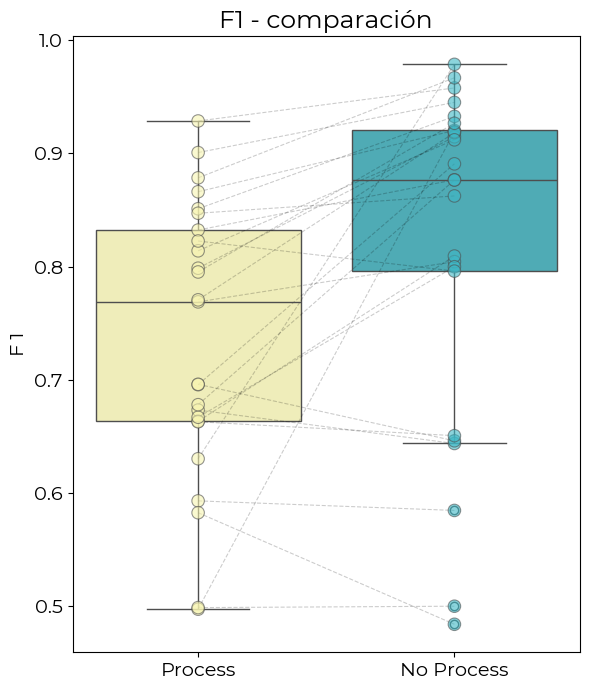

In [22]:
df = pd.DataFrame({'Process': f1_process, 'No Process': f1_noprocess})

font_path        = '../02-Letra-plot/Montserrat-Regular.ttf'
montserrat       = fm.FontProperties(fname=font_path)

plt.figure(figsize=(6, 7), facecolor='white')

# Configurar colores personalizados para la cuadrícula
plt.rc('grid',   color='#CFCFCF', linestyle='--', linewidth=0.7)
plt.rc('axes',   facecolor='white')

# Crea el box plot
sns.boxplot(data=df,palette=["#F8F5B1", "#3EB8C6"])
sns.stripplot(data=df, size=9, jitter=False, linewidth=0.8, alpha=0.6, palette=['#F8F5B1', '#3EB8C6'])

for i in range(len(f1_process)):
    plt.plot([0, 1], [f1_process[i], f1_noprocess[i]], linestyle='--', linewidth=0.8, alpha=0.2, color='black')

plt.title('F1 - comparación', fontproperties=montserrat, fontsize=18, color='black')
plt.ylabel('F 1', fontproperties=montserrat, fontsize=14,color='black')


# Aplicar la fuente Montserrat a las etiquetas de los ejes
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_4521/4185343384.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
/tmp/ipykernel_4521/4185343384.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)


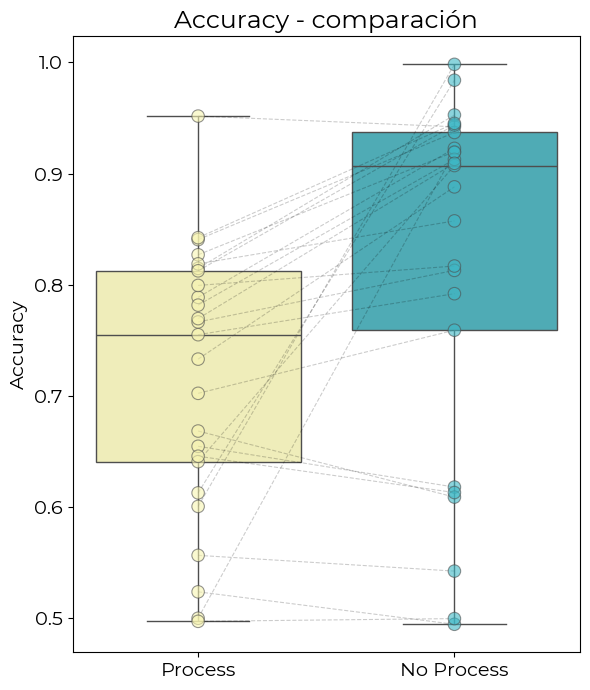

In [24]:
df = pd.DataFrame({'Process': accuracy_process, 'No Process': accuracy_noprocess})

font_path        = '../02-Letra-plot/Montserrat-Regular.ttf'
montserrat       = fm.FontProperties(fname=font_path)

plt.figure(figsize=(6, 7), facecolor='white')

# Configurar colores personalizados para la cuadrícula
plt.rc('grid',   color='#CFCFCF', linestyle='--', linewidth=0.7)
plt.rc('axes',   facecolor='white')

# Crea el box plot
sns.boxplot(data=df,palette=["#F8F5B1", "#3EB8C6"])
sns.stripplot(data=df, size=9, jitter=False, linewidth=0.8, alpha=0.6, palette=['#F8F5B1', '#3EB8C6'])

for i in range(len(accuracy_process)):
    plt.plot([0, 1], [accuracy_process[i], accuracy_noprocess[i]], linestyle='--', linewidth=0.8, alpha=0.2, color='black')

plt.title('Accuracy - comparación', fontproperties=montserrat, fontsize=18, color='black')
plt.ylabel('Accuracy', fontproperties=montserrat, fontsize=14,color='black')


# Aplicar la fuente Montserrat a las etiquetas de los ejes
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_4521/3331934766.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
/tmp/ipykernel_4521/3331934766.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)


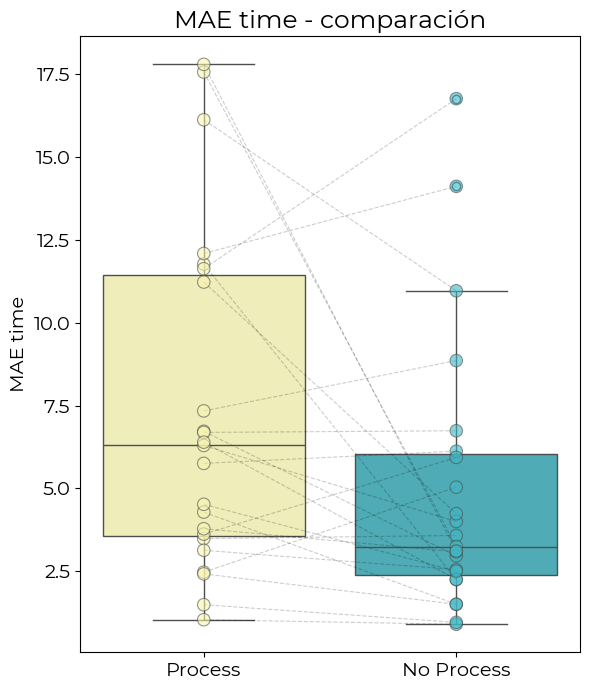

In [25]:
df = pd.DataFrame({'Process': MAE_time_process, 'No Process': MAE_time_noprocess})

font_path        = '../02-Letra-plot/Montserrat-Regular.ttf'
montserrat       = fm.FontProperties(fname=font_path)

plt.figure(figsize=(6, 7), facecolor='white')

# Configurar colores personalizados para la cuadrícula
plt.rc('grid',   color='#CFCFCF', linestyle='--', linewidth=0.7)
plt.rc('axes',   facecolor='white')

# Crea el box plot
sns.boxplot(data=df,palette=["#F8F5B1", "#3EB8C6"])
sns.stripplot(data=df, size=9, jitter=False, linewidth=0.8, alpha=0.6, palette=['#F8F5B1', '#3EB8C6'])

for i in range(len(MAE_time_process)):
    plt.plot([0, 1], [MAE_time_process[i], MAE_time_noprocess[i]], linestyle='--', linewidth=0.8, alpha=0.2, color='black')

plt.title('MAE time - comparación', fontproperties=montserrat, fontsize=18, color='black')
plt.ylabel('MAE time', fontproperties=montserrat, fontsize=14,color='black')


# Aplicar la fuente Montserrat a las etiquetas de los ejes
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontproperties=montserrat, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=montserrat, fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()